# Comparable table for all PCA's methods ( time/data lost/ etc. )

DataSet = make_classification(n_samples=50000, n_features=500, n_redundant=100, n_informative=20, return_X_y=True, random_state=42)

| Method | Time  | K   | Use Case                 | built-in | DataLoss | Comp. Ratio       |
|--------|-------|-----|--------------------------|----------|----------|-------------------|
| PCA    | 208ms | 100 | Start simple             | Y        |          | 80% (38Mb/7.62Mb) |
| k-PCA  | 2m3s  | 100 | Nonlinear manifolds      | Y        |          |                   |
| LLE    | 2m11s | 100 | Nonlinear manifolds      | Y        |          |                   |
| t-SNE  | 4m17s | 3   | Clustering               | Y        |          |                   |
| UMAP   | N/A   | 100 | Clustering               | N        |          |                   |
| MDS    | >15m  | 100 | Only distances available | Y        |          |                   |
| LDA    | 2s    | 1   | Classification           | Y        |          |                   |
| Isomap | 2m25s | 100 | Nonlinear manifolds      | Y        |          |                   |


 - PCA (Principal Component Analysis)
- kernel PCA (Polynomial, RBF)
- LLE (Locally Linear Embedding)
- t-SNE (t-Distributed Stochastic Neighbor Embedding)

### PCA recommendation table

| **Algorithm**                                            | **Use Case**                                             | **ML Models**                                                           | **Comments**                                                                                                                        |
|:---------------------------------------------------------|:---------------------------------------------------------|:------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------|
| **PCA (Principal Component Analysis)**                   | Unsupervised, Preprocessing, Visualization               | Linear Regression, Logistic Regression, SVM, K-Means, KNN               | Best for linear dimensionality reduction; assumes linear correlation; fast and interpretable.                                       |
| **Kernel PCA**                                           | Unsupervised, Nonlinear Feature Extraction               | SVM, Kernel Ridge Regression                                            | Extension of PCA for nonlinear data; choice of kernel (RBF, poly, sigmoid) is critical; computationally heavier.                    |
| **LLE (Locally Linear Embedding)**                       | Unsupervised, Nonlinear Manifold Learning, Visualization | Used before clustering or for data compression                          | Preserves local neighborhood relationships; sensitive to noise and number of neighbors; poor for extrapolation.                     |
| **t-SNE (t-Distributed Stochastic Neighbor Embedding)**  | Unsupervised, Visualization (2D/3D)                      | Used mainly for exploratory data visualization (not as input to models) | Excellent for visualizing high-dimensional data; non-linear; high computational cost; not good for large datasets.                  |
| **UMAP (Uniform Manifold Approximation and Projection)** | Unsupervised, Visualization, Feature Extraction          | Clustering (DBSCAN, K-Means), classification preprocessing              | Faster and more scalable alternative to t-SNE; preserves both local and global structure; tunable via `n_neighbors` and `min_dist`. |
| **MDS (Multidimensional Scaling)**                       | Unsupervised, Visualization, Distance Preservation       | Used for similarity analysis or exploratory visualization               | Preserves pairwise distances; computationally expensive for large n; less flexible than t-SNE or UMAP.                              |
| **LDA (Linear Discriminant Analysis)**                   | **Supervised**, Classification, Dimensionality Reduction | Logistic Regression, SVM, Decision Trees                                | Maximizes class separability; works only with labeled data; assumes normality and equal class covariance.                           |
| **ISOMAP (Isometric Mapping)**                           | Unsupervised, Nonlinear Manifold Learning, Visualization | Clustering, Preprocessing before nonlinear models                       | Preserves geodesic (manifold) distances; good for manifold-shaped data; struggles with noise and disconnected graphs.               |


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.datasets import fetch_openml, make_classification, make_swiss_roll
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Load the data
data = pd.read_csv('../dataset/500hits.csv', encoding='latin1')
data = data.drop('PLAYER', axis=1)
X  = data.drop('HOF', axis=1)
y = data['HOF']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
scaler = StandardScaler()
scaled_x = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_x, columns=X.columns)
print(X_train.describe().round(3))

           YRS        G       AB        R        H       2B       3B       HR  \
count  372.000  372.000  372.000  372.000  372.000  372.000  372.000  372.000   
mean    -0.000    0.000    0.000    0.000   -0.000    0.000   -0.000    0.000   
std      1.001    1.001    1.001    1.001    1.001    1.001    1.001    1.001   
min     -2.122   -1.998   -1.582   -1.879   -1.226   -2.138   -1.459   -1.274   
25%     -0.710   -0.696   -0.761   -0.737   -0.789   -0.714   -0.790   -0.851   
50%     -0.004   -0.169   -0.227   -0.167   -0.221   -0.160   -0.237   -0.193   
75%      0.702    0.582    0.519    0.521    0.450    0.576    0.629    0.645   
max      3.174    3.507    3.755    3.944    3.869    4.299    3.636    3.860   

           RBI       BB       SO       SB       CS       BA  
count  372.000  372.000  372.000  372.000  372.000  372.000  
mean     0.000    0.000    0.000    0.000   -0.000    0.000  
std      1.001    1.001    1.001    1.001    1.001    1.001  
min     -1.781   -1.65

In [5]:
pca1 = PCA()
X_pca1 = pca1.fit_transform(X_train)
print(pca1.explained_variance_ratio_) # piece of every component in the total variance

[4.22448478e-01 2.36582583e-01 1.06085103e-01 6.90539321e-02
 5.53473687e-02 3.12393498e-02 2.16795389e-02 2.06023604e-02
 1.69824087e-02 9.19751096e-03 5.50710620e-03 4.23116668e-03
 9.07192285e-04 1.35900385e-04]


In [6]:
cumsum = np.cumsum(pca1.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d) # number of components to explain 95% of the variance

8


Text(0.5, 1.0, 'Explained Variance vs Number of Components')

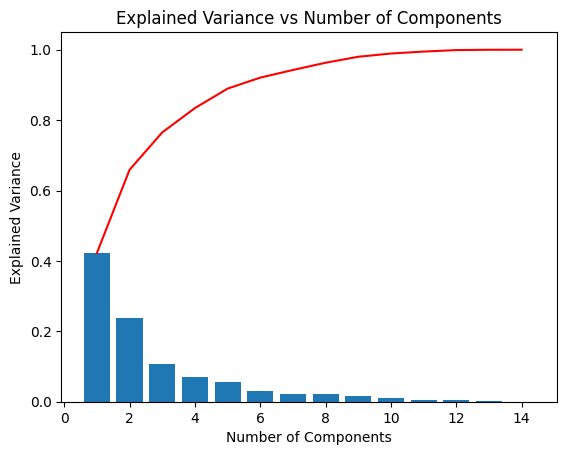

In [7]:
# Cumulative Explained Variance
plt.bar(range(1, len(pca1.explained_variance_ratio_)+1), pca1.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Number of Components')
plt.plot(range(1, len(pca1.explained_variance_ratio_)+1),
         np.cumsum(pca1.explained_variance_ratio_),
         c='red',
         label='Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')

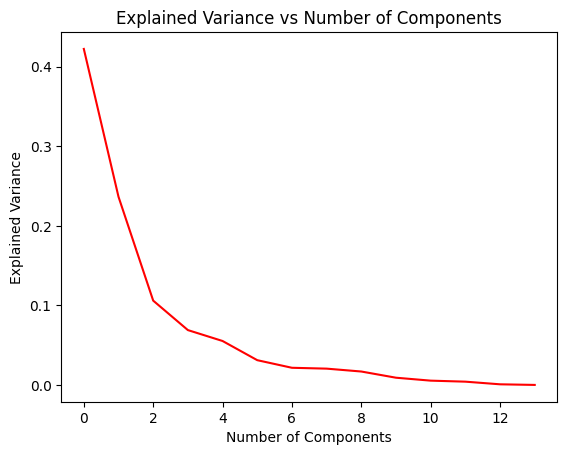

In [8]:
plt.plot(pca1.explained_variance_ratio_, c='red', label='Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.show()

In [9]:
pca2 = PCA(n_components=0.95)
X_pca2 = pca2.fit_transform(X_train)
print(X_pca2.shape)
print(pca2.explained_variance_ratio_)

(372, 8)
[0.42244848 0.23658258 0.1060851  0.06905393 0.05534737 0.03123935
 0.02167954 0.02060236]


Data Frame  (372, 2)
Variance ration for each component [0.42244848 0.23658258]
Variance lost:  0.34096893831695807


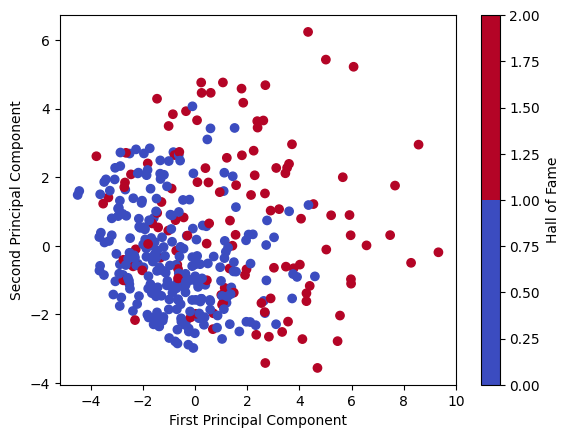

In [10]:
pca_2c = PCA(n_components=2)
X_pca_2c = pca_2c.fit_transform(X_train)
print('Data Frame ', X_pca_2c.shape)
print('Variance ration for each component', pca_2c.explained_variance_ratio_)

print('Variance lost: ', 1 - sum(pca_2c.explained_variance_ratio_))

colormap = plt.colormaps.get_cmap('coolwarm').resampled(2)
plt.figure()
scatter = plt.scatter(X_pca_2c[:, 0], X_pca_2c[:, 1], c=y_train, cmap=colormap)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Hall of Fame')
plt.show()

In [11]:
pca_3c = PCA(n_components=3)
X_pca_3c = pca_3c.fit_transform(X_train)
print(X_pca_3c.shape)

(372, 3)


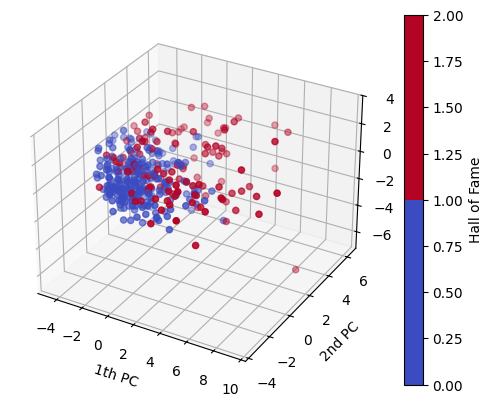

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3c[:, 0], X_pca_3c[:, 1], X_pca_3c[:, 2], c=y_train, cmap=colormap)
ax.set_xlabel('1th PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
fig.colorbar(scatter, ax=ax, label='Hall of Fame')
plt.show()

In [13]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Code to generate Figure 8–4. Swiss roll dataset:

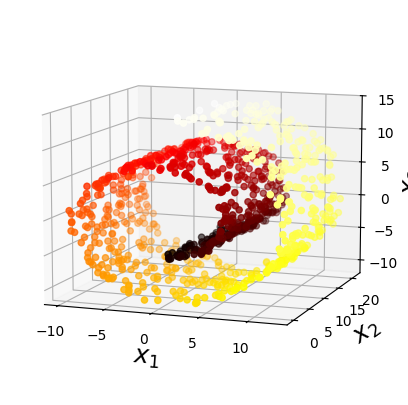

In [14]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

Code to generate Figure 8–5. Squashing by projecting onto a plane (left) versus unrolling the Swiss roll (right):

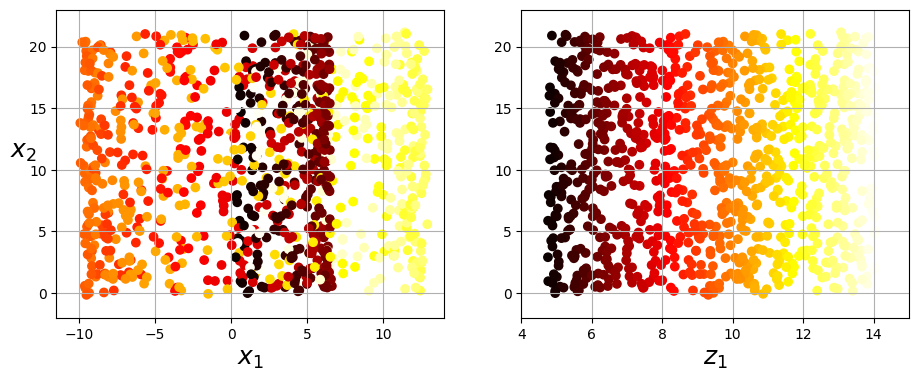

In [15]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis((4, 15, axes[2], axes[3]))
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

Code to generate Figure 8–6. The decision boundary may not always be simpler with lower dimensions:

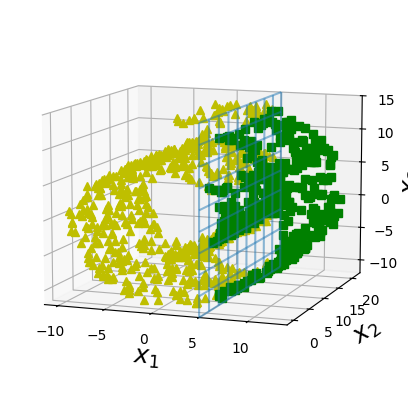

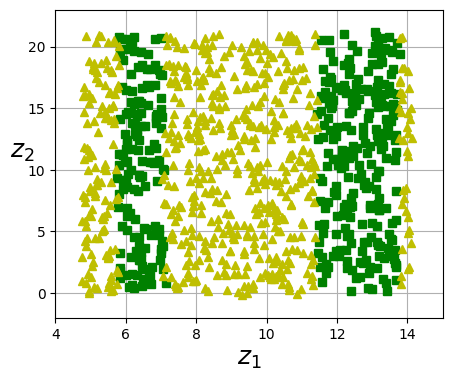

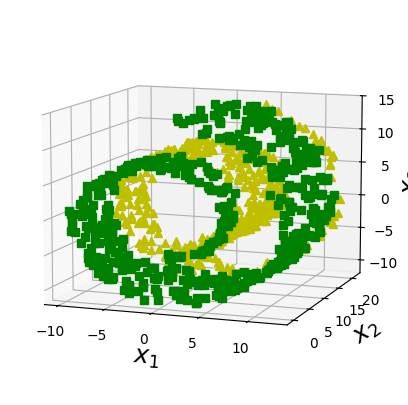

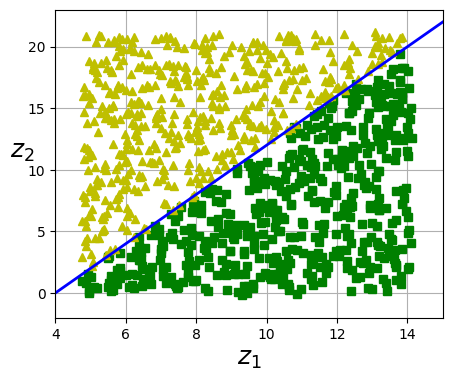

In [16]:
axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis((4, 15, axes[2], axes[3]))
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis((4, 15, axes[2], axes[3]))
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

Сode to generate Figure 8–7. Selecting the subspace to project on:

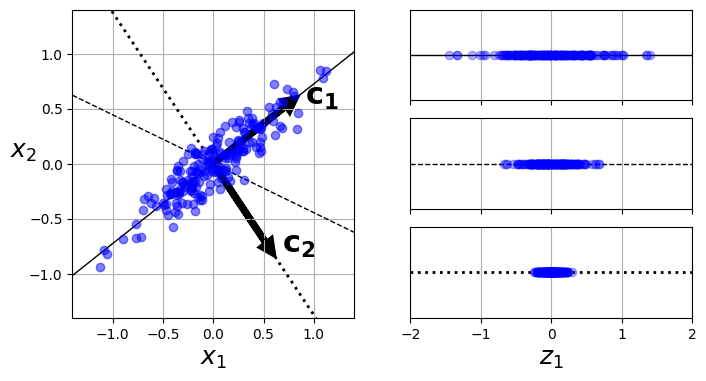

In [17]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

Choosing the Right Number of Dimensions
Warning: since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this and keep the same code as in the book, we set as_frame=True.

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [21]:
d # number of dimensions to explain 95% of the variance

np.int64(154)

Code to generate Figure 8–8. Explained variance as a function of the number of dimensions:

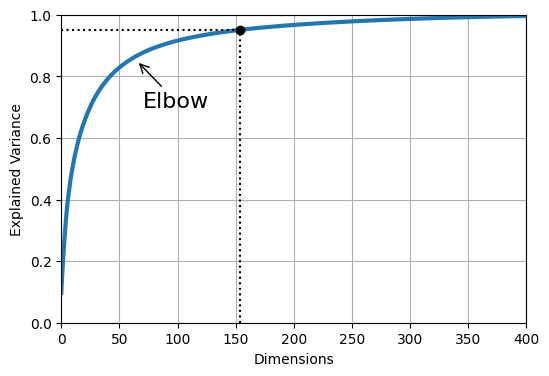

In [22]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis((0, 400, 0, 1))
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [23]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

pca.n_components_

np.int64(154)

In [24]:
np.sum(pca.explained_variance_ratio_)

np.float64(0.9504334914295708)

PCA for Compression

In [25]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Code to generate Figure 8–9. MNIST compression that preserves 95% of the variance:

In [26]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

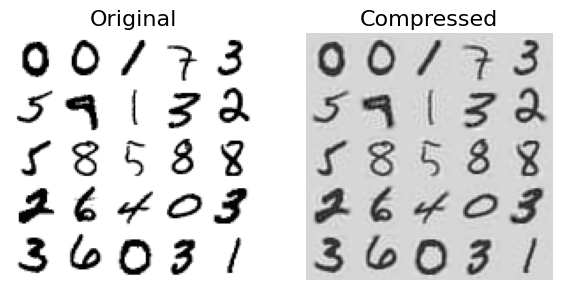

In [27]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

In [28]:
X_reduced_pca = X_reduced

Randomized PCA

In [29]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)
X_recovered = rnd_pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Compressed')

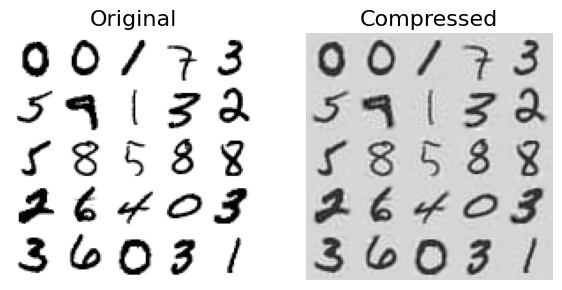

In [30]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

Incremental PCA

In [31]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)
X_recovered = inc_pca.inverse_transform(X_reduced)

....................................................................................................

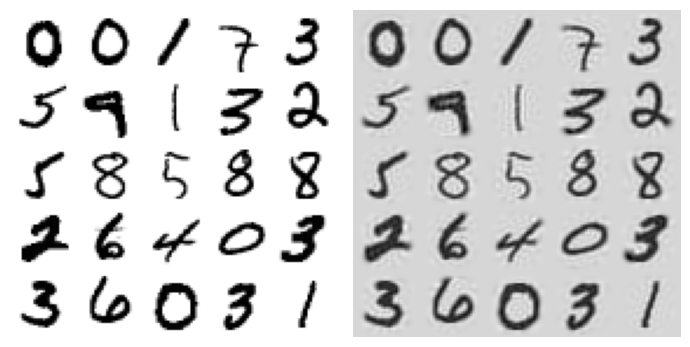

In [32]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.tight_layout()

Kernel PCA

In [33]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)

X_reduced = rbf_pca.fit_transform(X)
X_recovered = rbf_pca.inverse_transform(X_reduced)

MemoryError: Unable to allocate 36.5 GiB for an array with shape (70000, 70000) and data type float64

Selecting a Kernel and Tuning Hyperparameters

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", DecisionTreeClassifier())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = RandomizedSearchCV(clf, param_grid, cv=cv, return_train_score=False, verbose=0, n_iter=10, random_state=42)
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_score_)

Using LLE

In [5]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [6]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Code to generate Figure 8–12. Unrolled Swiss roll using LLE:

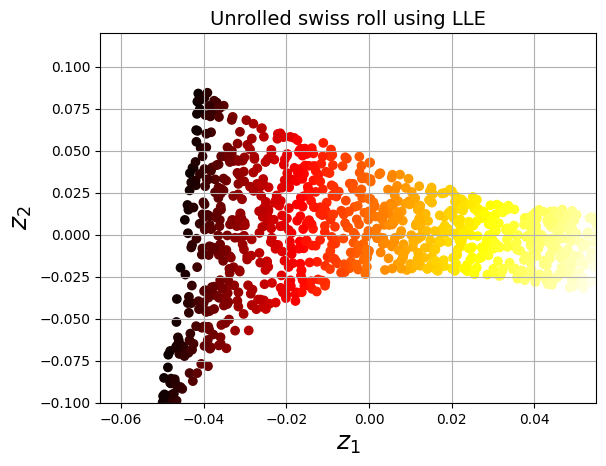

In [7]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis((-0.065, 0.055, -0.1, 0.12))
plt.grid(True)

plt.show()

Other Dimensionality Reduction Techniques

In [8]:
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [9]:
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [10]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [16]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

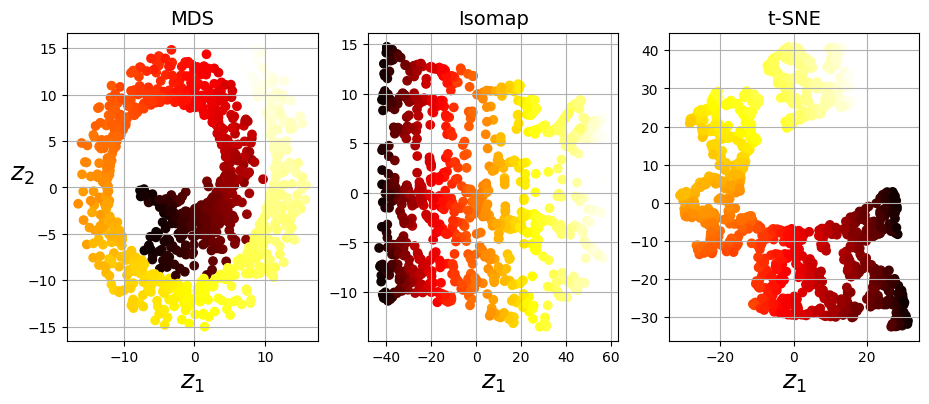

In [17]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

Exercise: Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

The MNIST dataset was loaded earlier.

In [19]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [20]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [21]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 73.86s


In [22]:

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

Exercise: Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

In [33]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [24]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print("Training took {:.2f}s".format(t1 - t0))

Training took 235.72s


In [25]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. See figure 8-6 (the manifold_decision_boundary_plot* plots above). If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

In [26]:
X_train_reduced.shape

(60000, 154)

In [27]:
X_train.shape

(60000, 784)

It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. :(

Let's see if it helps when using softmax regression:

In [29]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 26.37s


C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [31]:
log_clf2 = LogisticRegression(solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 8.60s


C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Nice! Reducing dimensionality led to over 2× speedup. :) Let's check the model's accuracy:

In [34]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

A very slight drop in performance, which might be a reasonable price to pay for a 2× speedup, depending on the application.

So there you have it: PCA can give you a formidable speedup... but not always!

Exercise: Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.

The MNIST dataset was loaded above.

Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [3]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [4]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

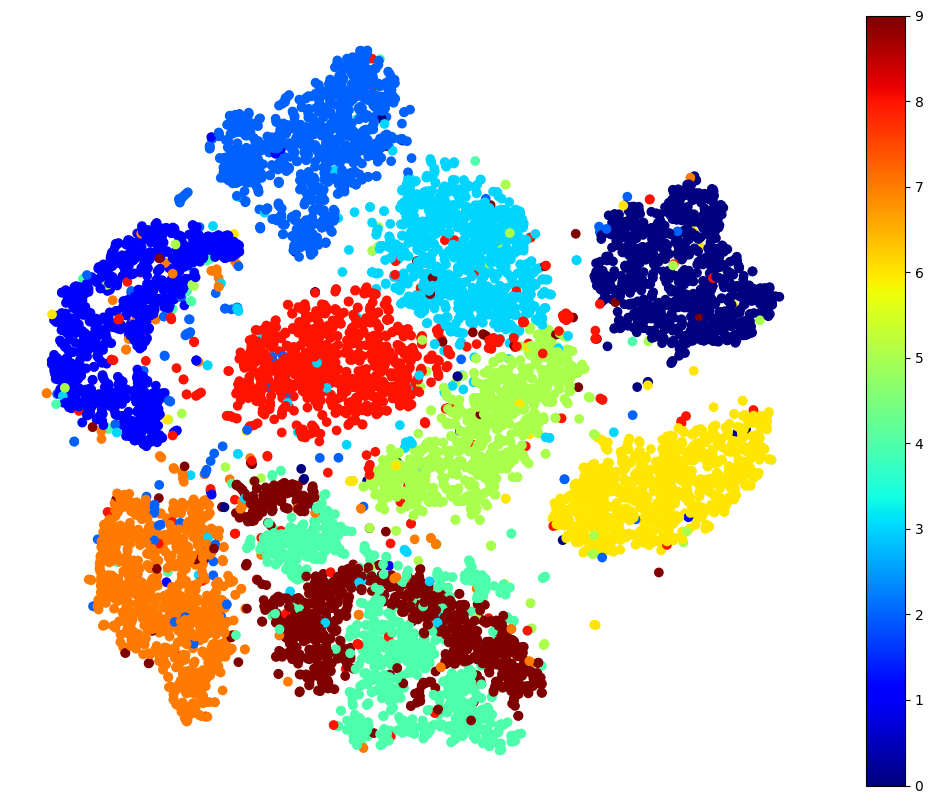

In [5]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

 This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters),
 and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

Let's focus on digits 2, 3 and 5, which seem to overlap a lot.

C:\Users\username\AppData\Local\Temp\ipykernel_8032\599151124.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


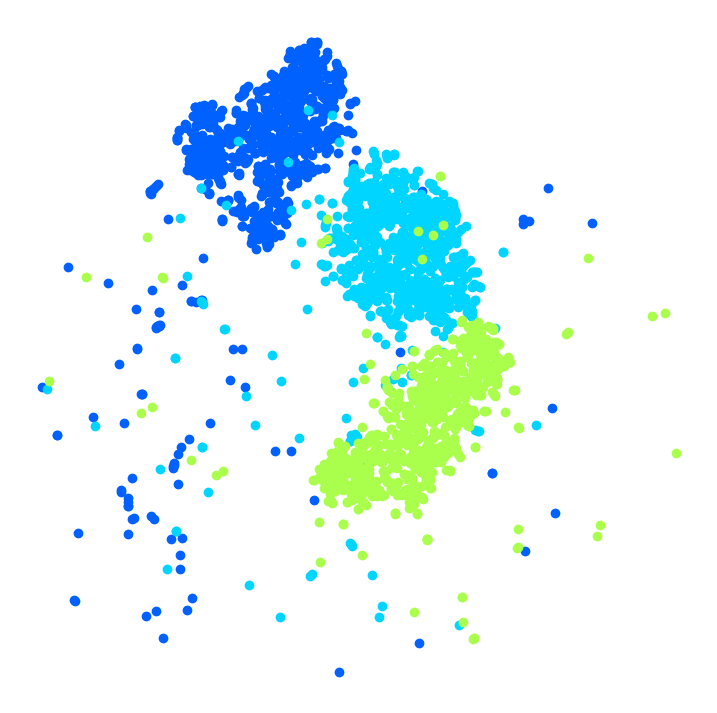

In [6]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [7]:
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

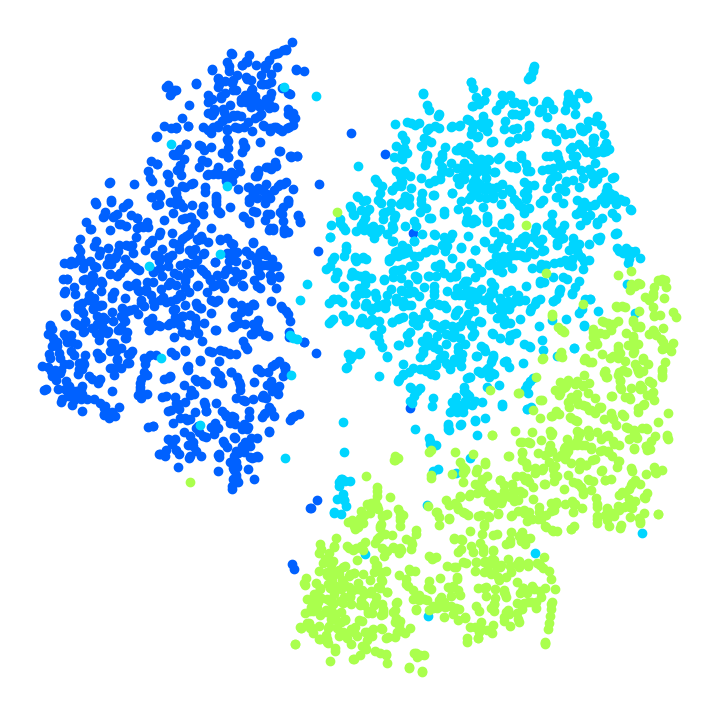

In [8]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now.

Exercise: Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.

Let's create a plot_digits() function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples (plot_lle_digits, based on a different digit dataset).

In [9]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


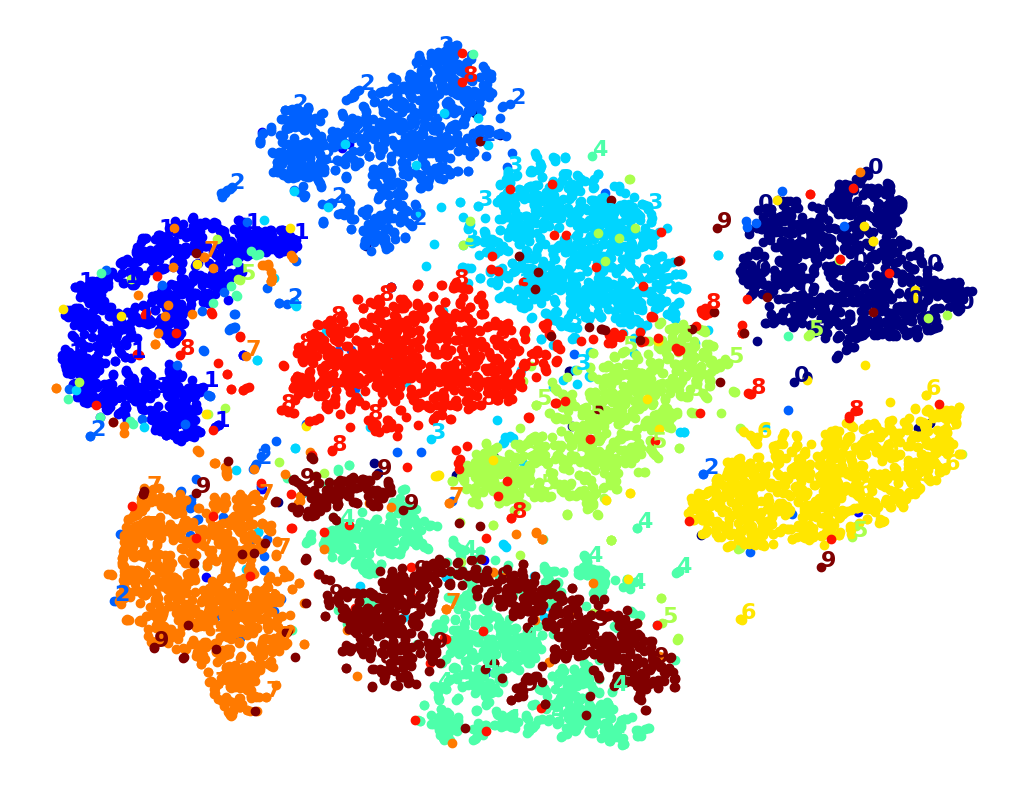

In [10]:
plot_digits(X_reduced, y)

Well that's okay, but not that beautiful. Let's try with the digit images:

C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


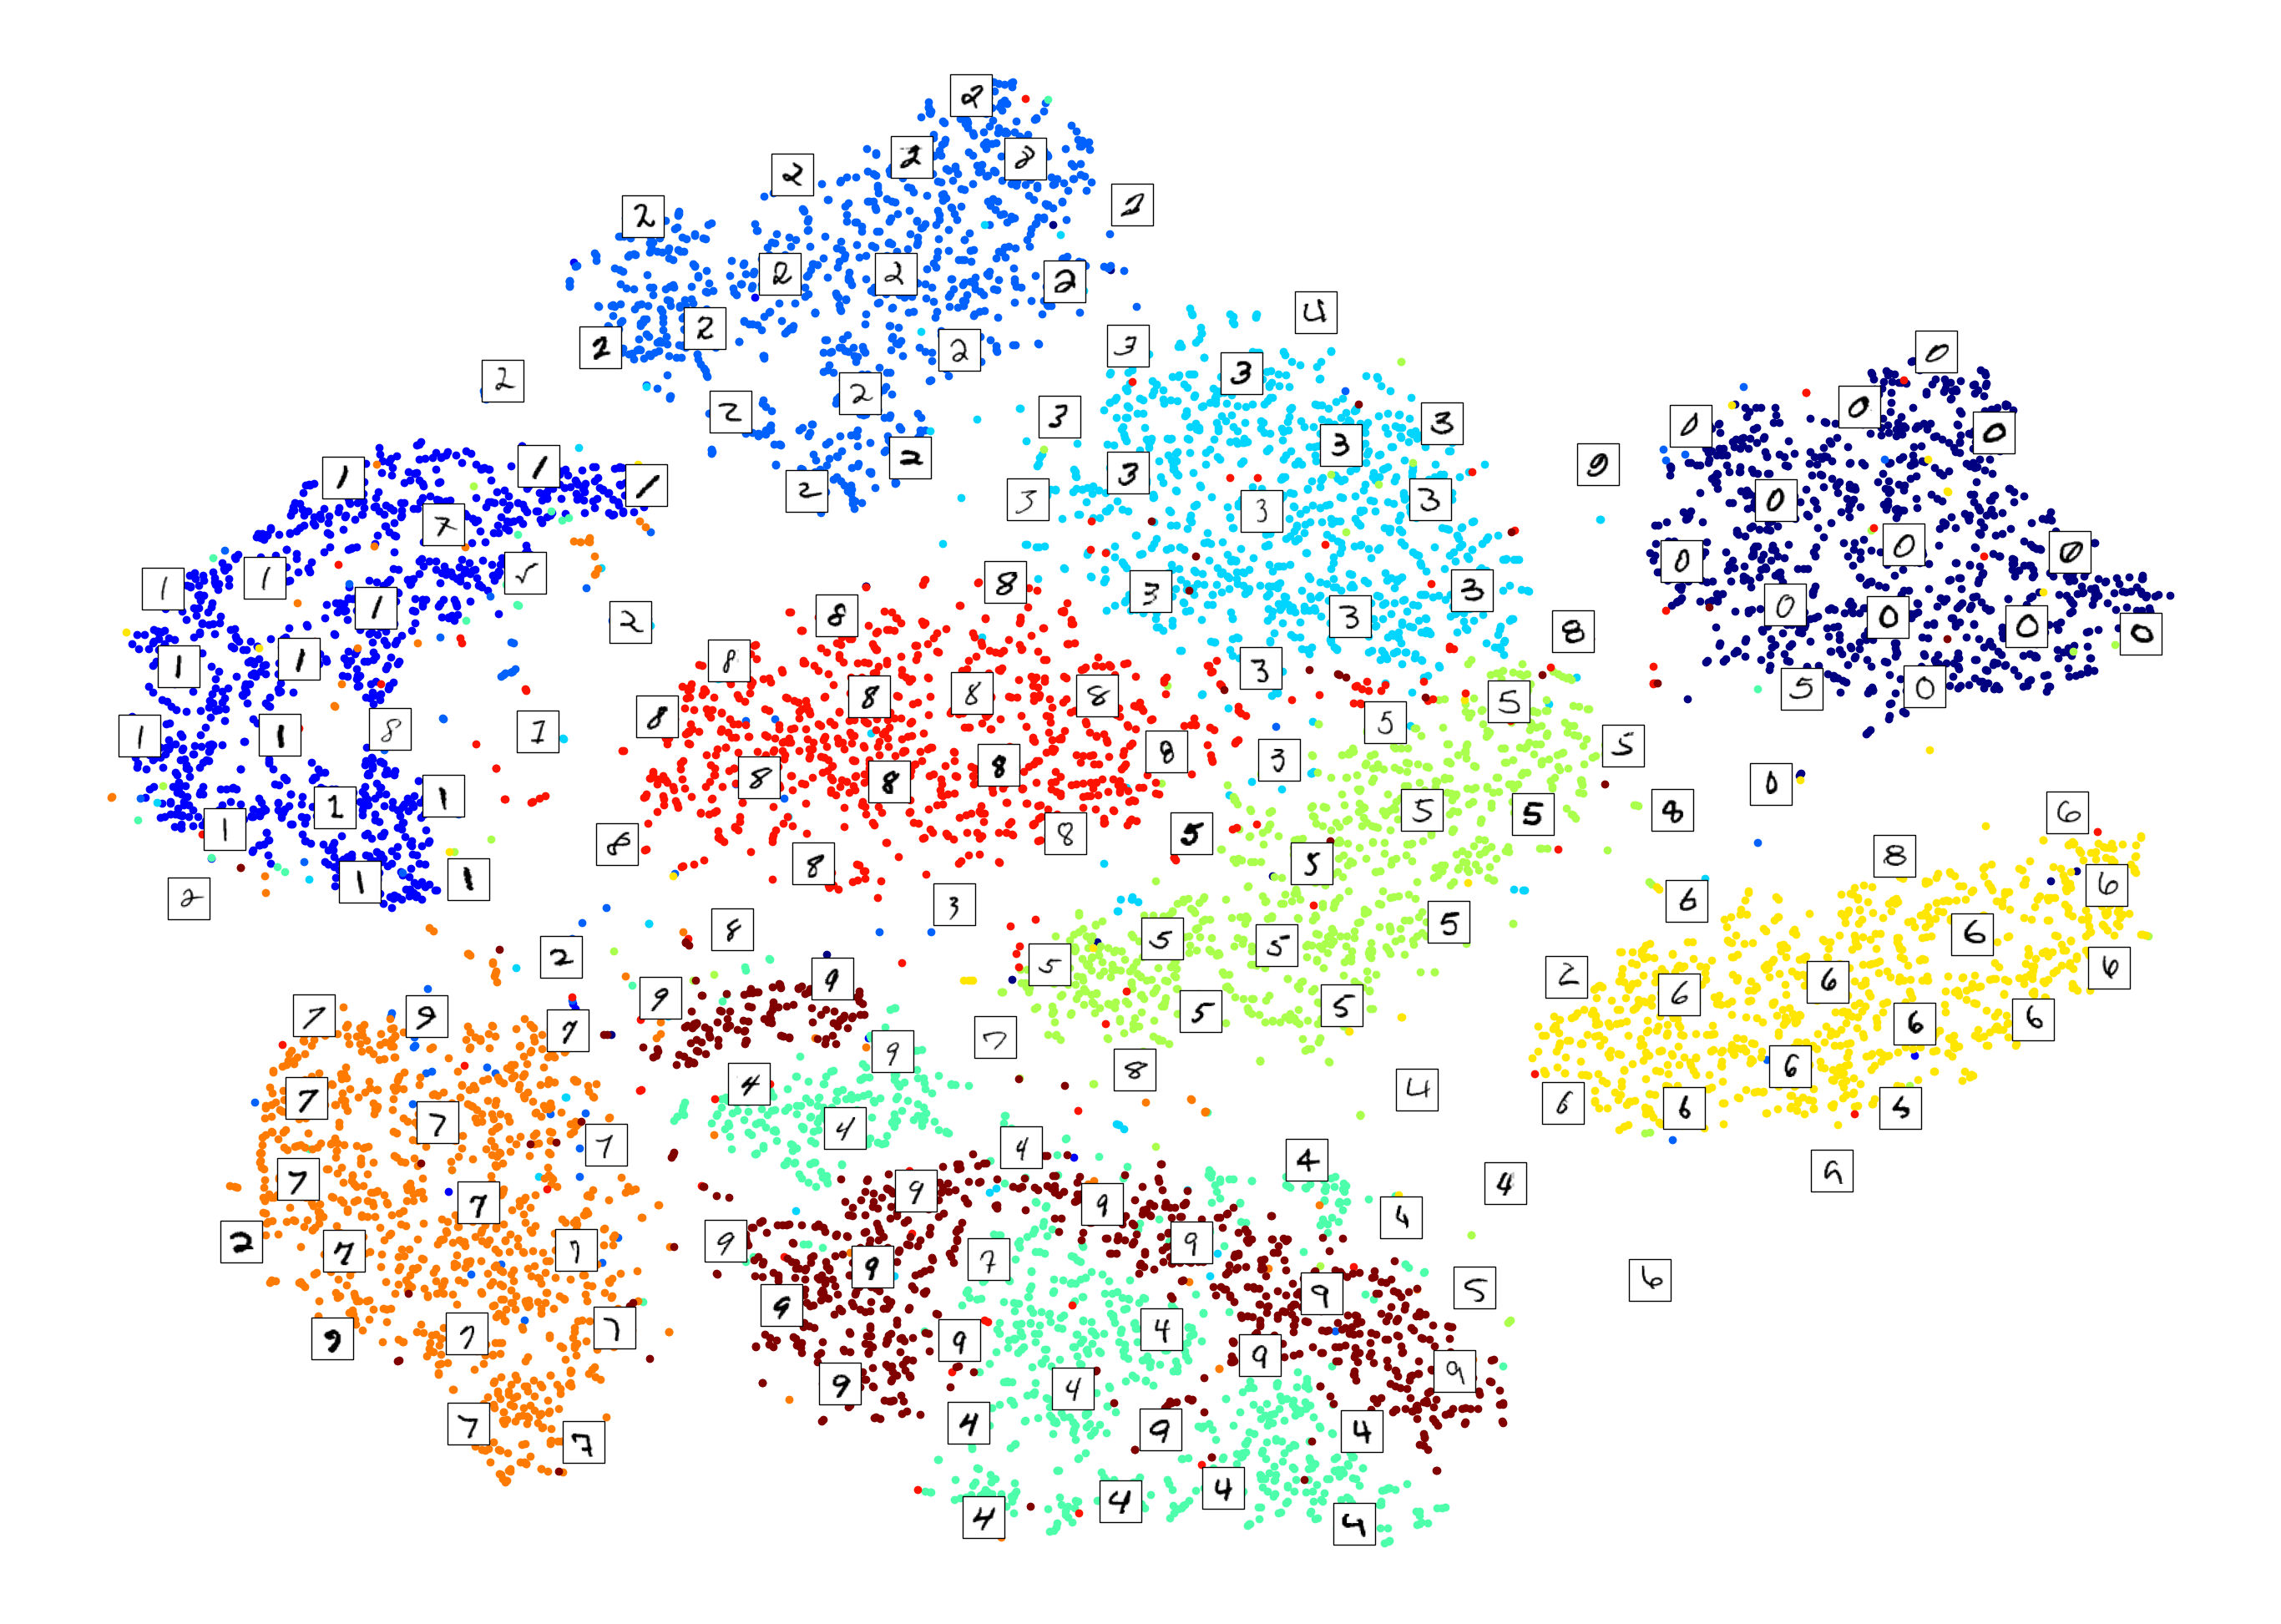

In [11]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


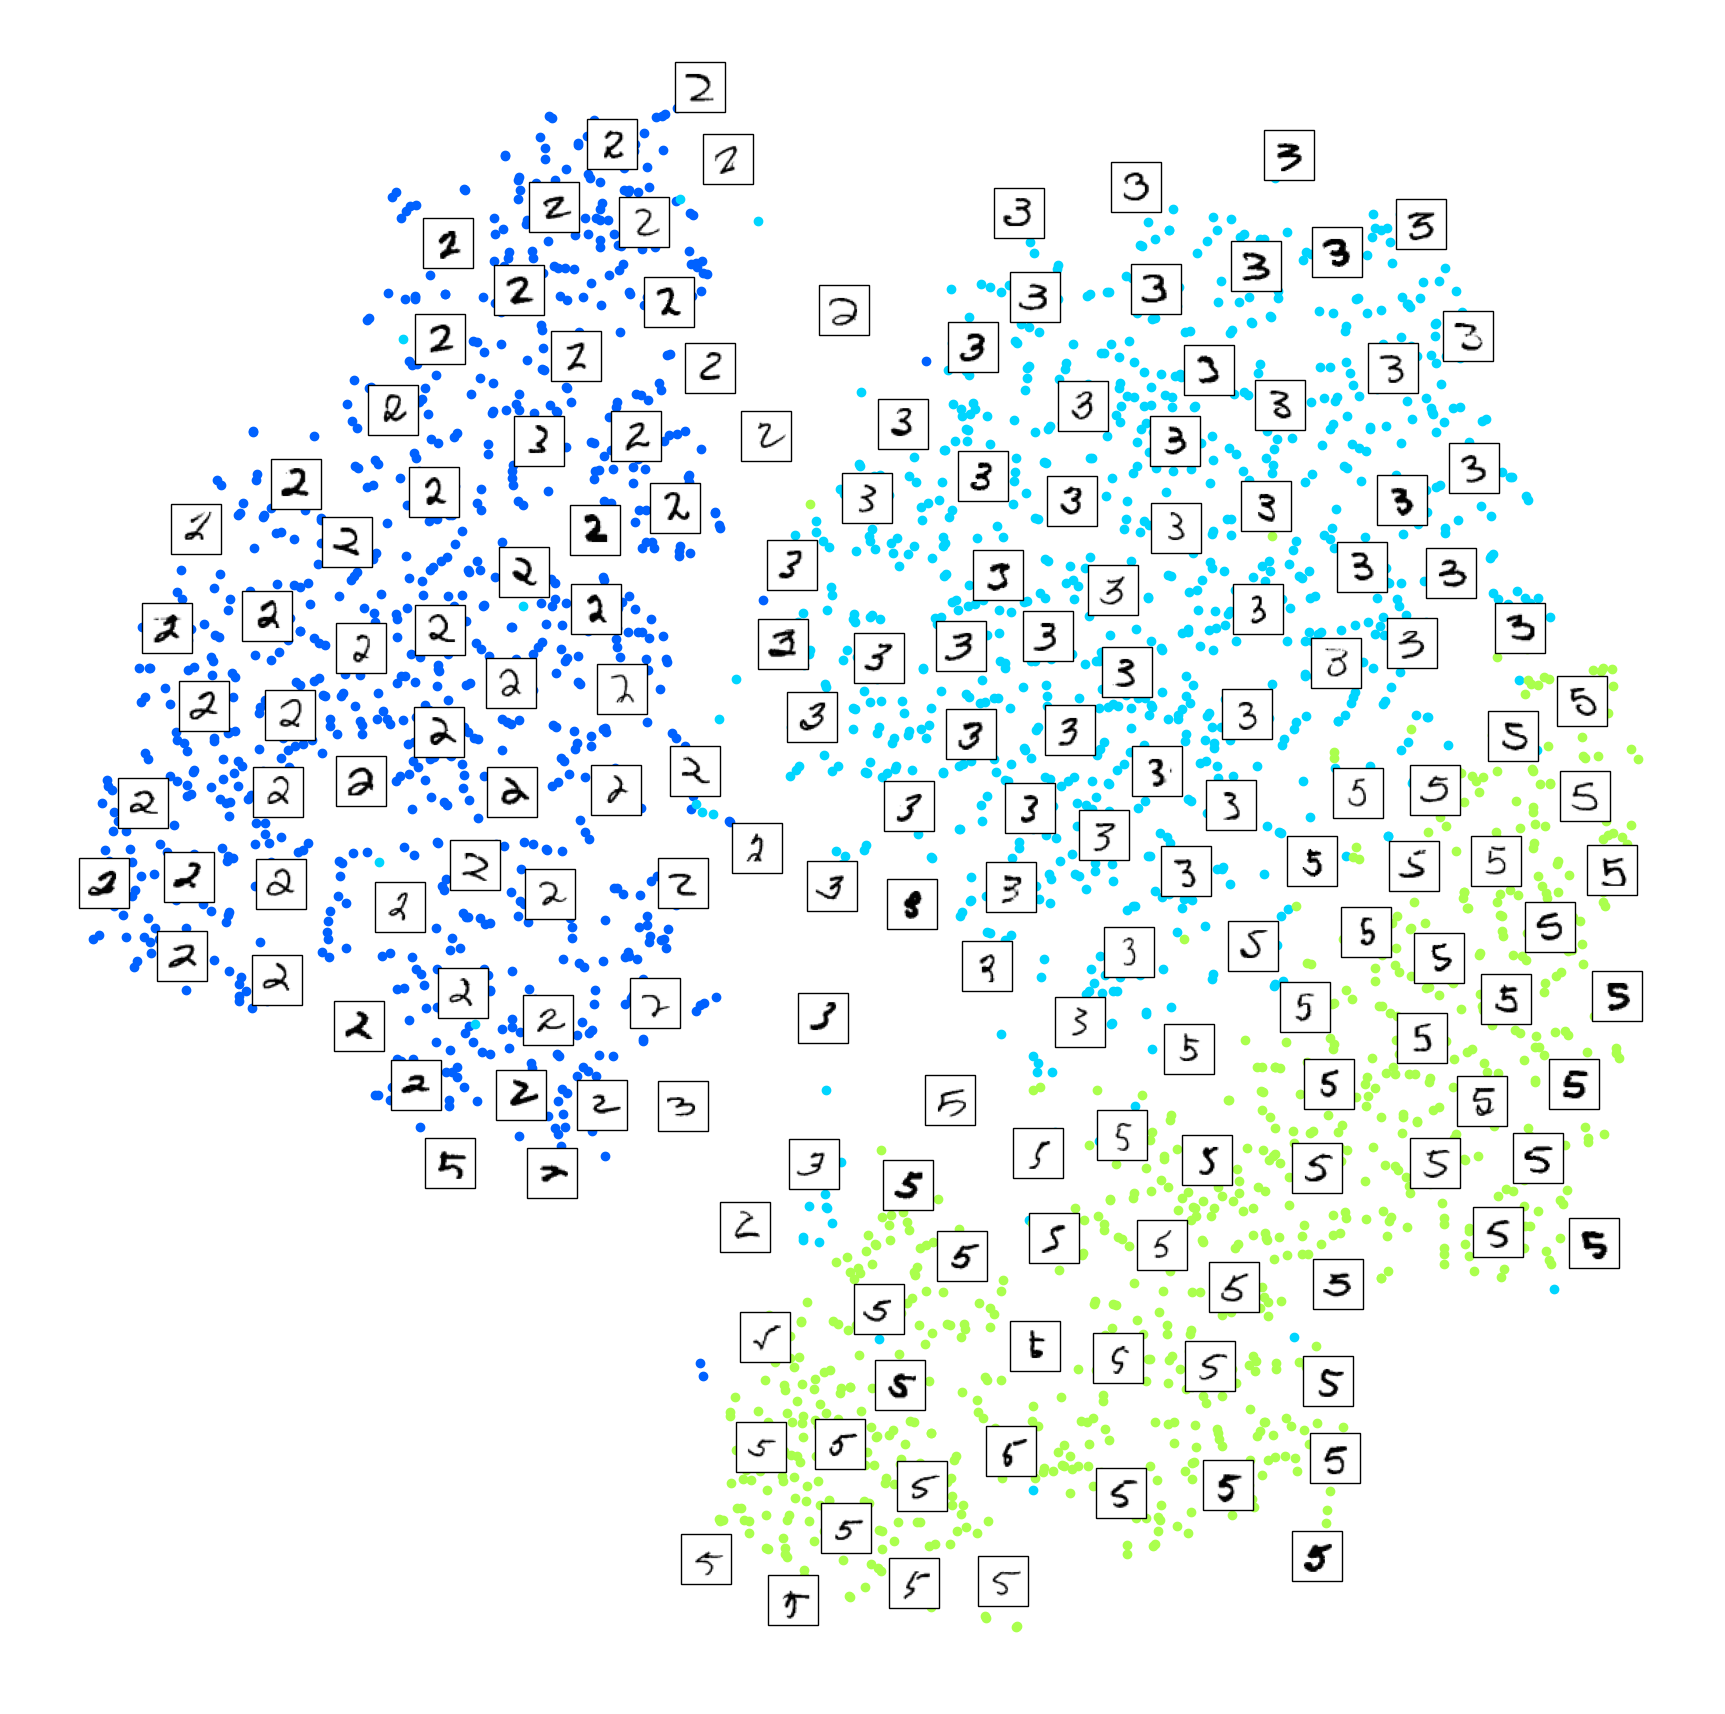

In [12]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

Exercise: Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

Let's start with PCA. We will also time how long it takes:

PCA took 0.5s.


C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


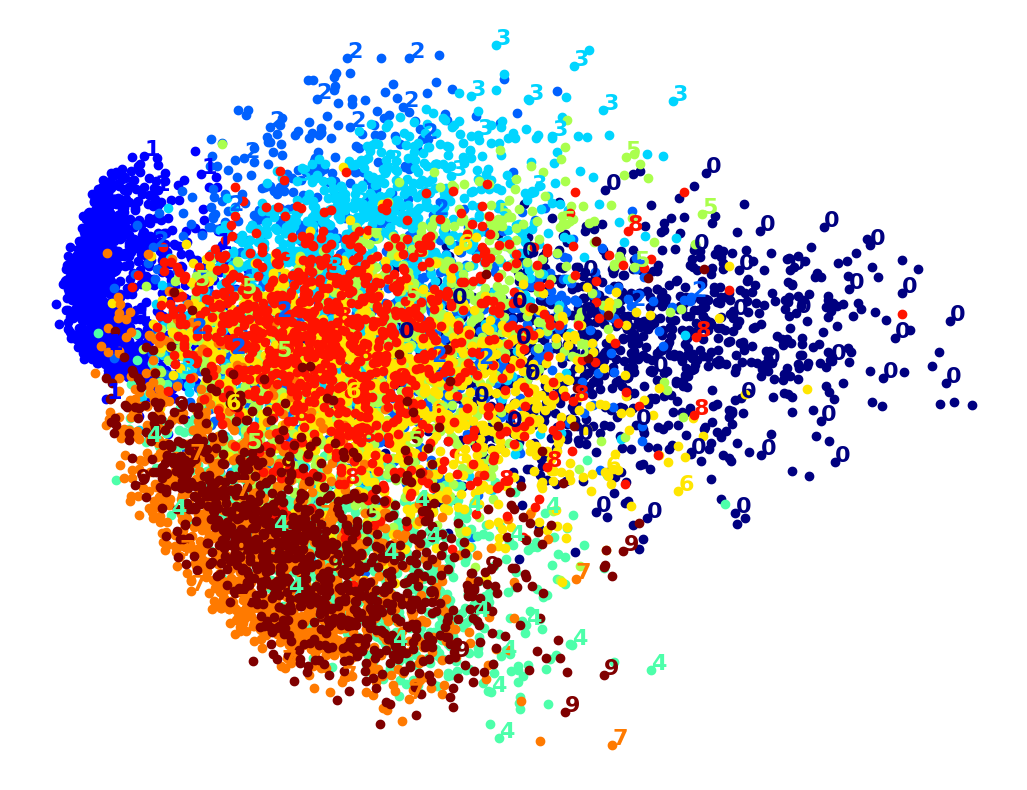

In [15]:
t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

LLE took 27.2s.


C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


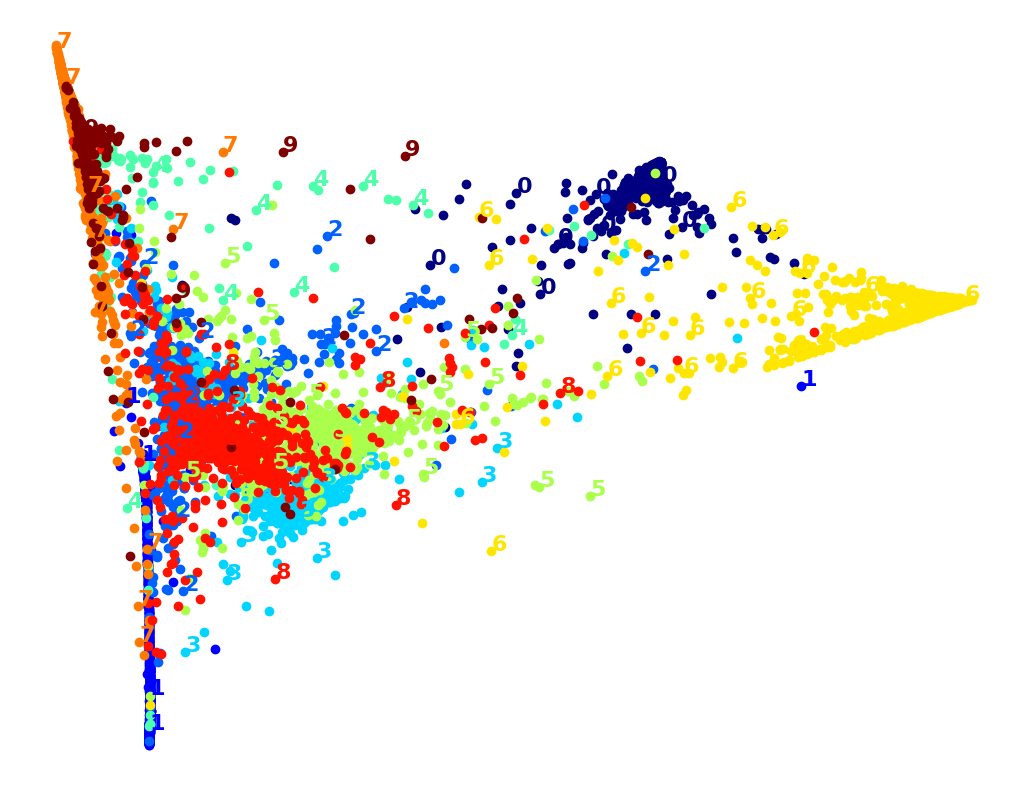

In [16]:
t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

PCA+LLE took 23.7s.


C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


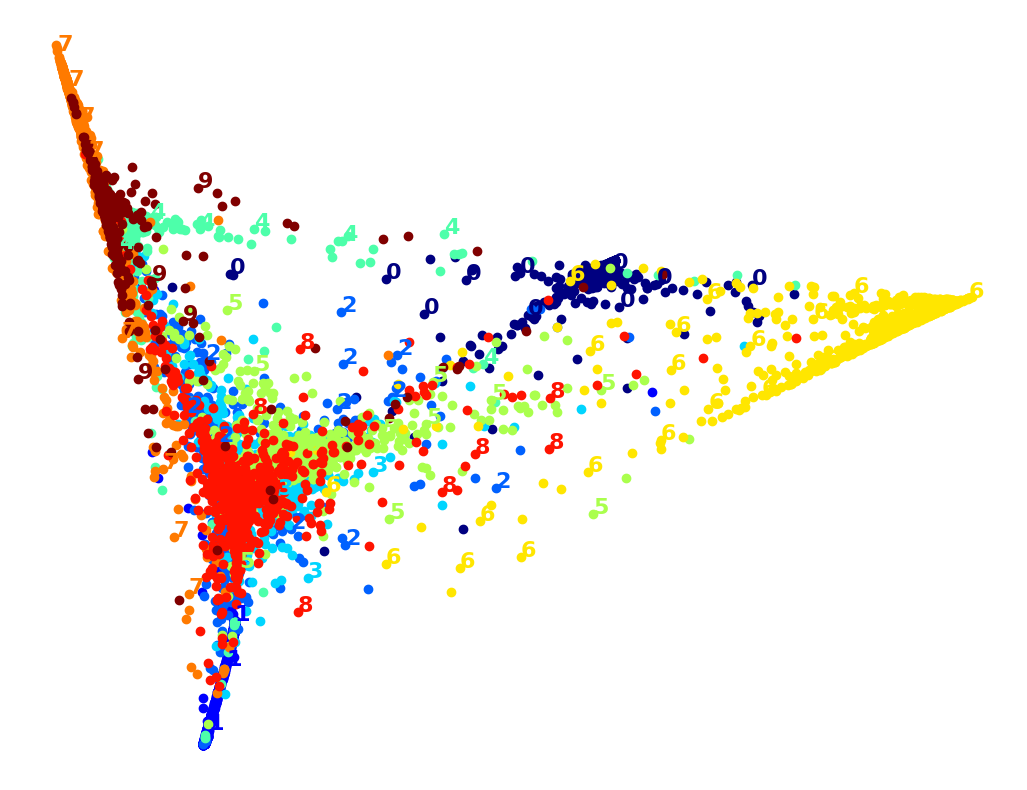

In [17]:

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

The result is more or less the same, but this time it was almost 4× faster.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


MDS took 279.3s (on just 2,000 MNIST images instead of 10,000).


C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


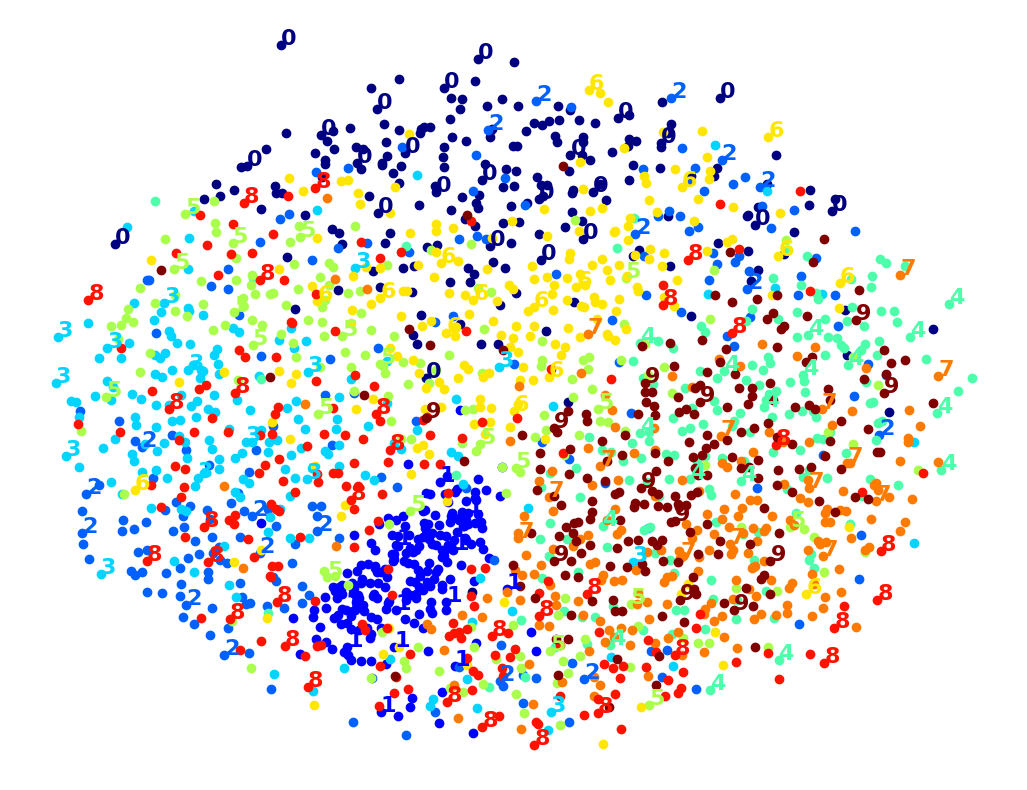

In [18]:
m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PCA+MDS took 246.1s (on 2,000 MNIST images).


C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


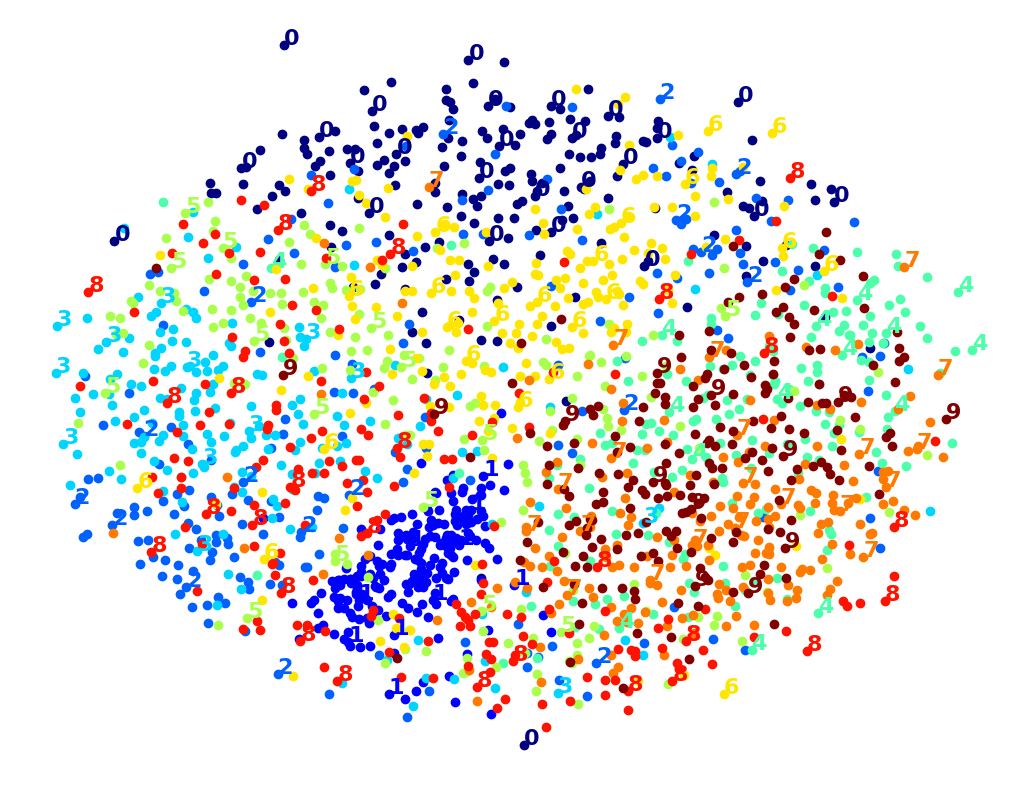

In [19]:
pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

Same result, and no speedup: PCA did not help (or hurt).

Let's try LDA:

LDA took 2.6s.


C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


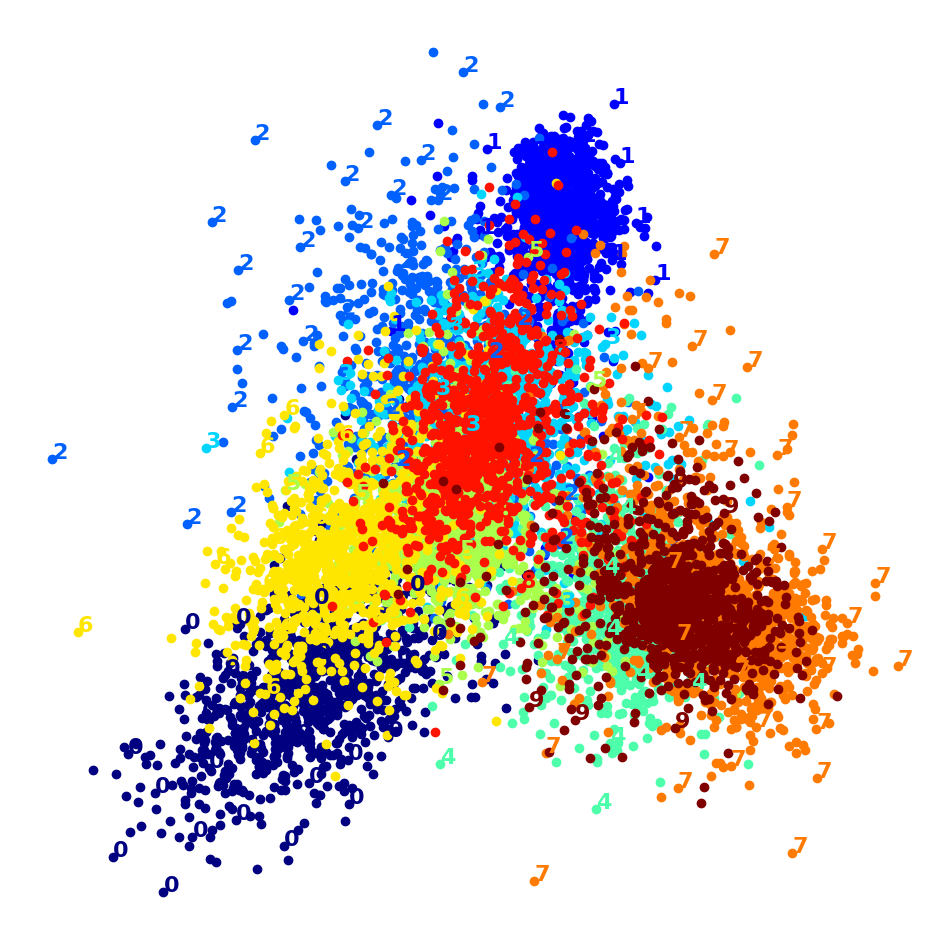

In [20]:
t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:

t-SNE took 68.4s.


C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


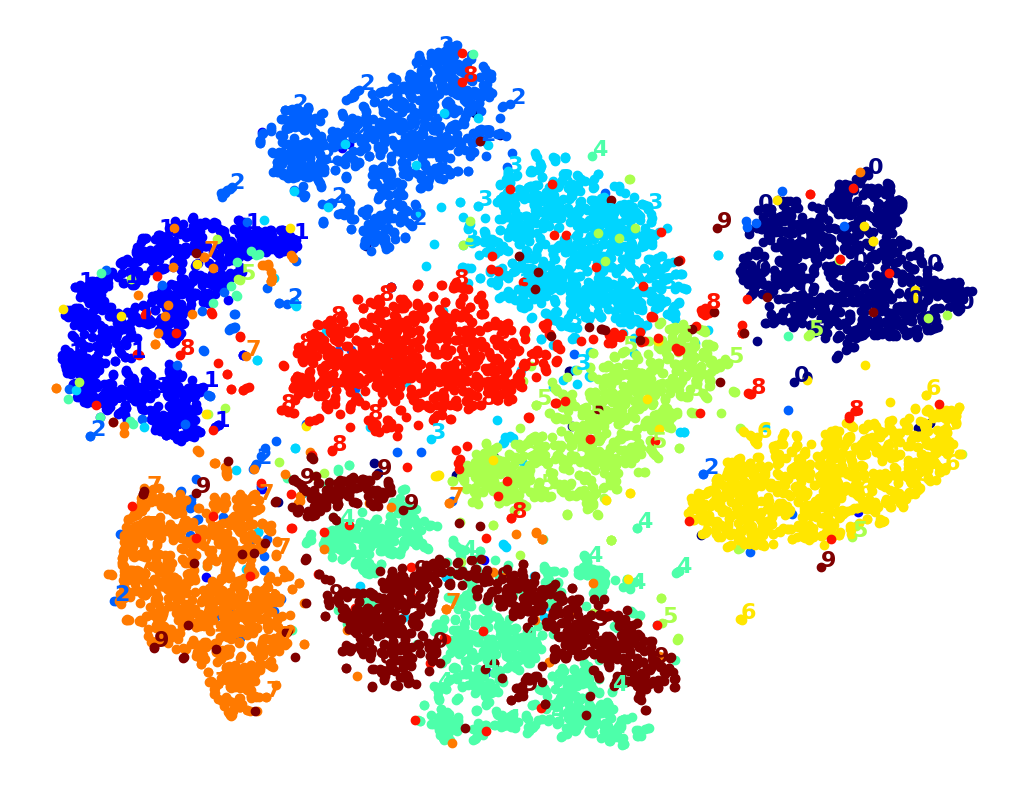

In [21]:
t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

It's twice slower than LLE, but still much faster than MDS, and the result looks great. Let's see if a bit of PCA can speed it up:

PCA+t-SNE took 70.3s.


C:\Users\username\AppData\Local\Temp\ipykernel_8032\1814386098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("jet")


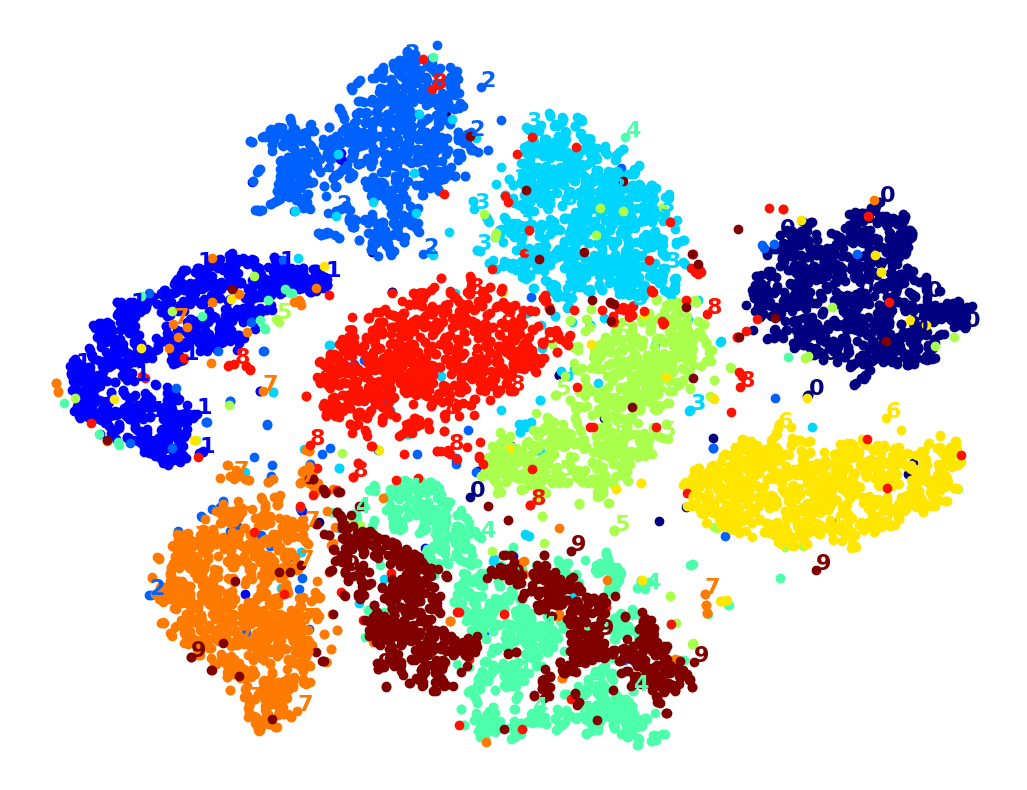

In [22]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Yes, PCA roughly gave us over 2x speedup, without damaging the result. We have a winner!

In [2]:
X, y = make_classification(n_samples=500, n_features=20, n_redundant=10, n_informative=5, return_X_y=True, random_state=42)

In [11]:
pca = PCA(n_components=4)
X2D = pca.fit_transform(X)

In [12]:
pca.explained_variance_ratio_

array([0.37762847, 0.2277561 , 0.15506816, 0.07345257])

##### we can see that 37% + 22% + 15% + 7% =  Dispersion 81%

### let's check how many features we need to gain Dispersion 95%

In [13]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

np.int64(8)

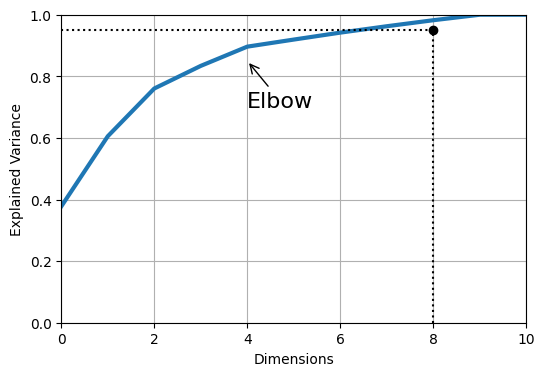

In [23]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis((0, 10, 0, 1))
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(4, 0.85), xytext=(4, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

### Let's check re-construction Error

In [24]:
pca = PCA(n_components=8)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)

In [28]:
mse = mean_squared_error(X, X_recovered)
print("Reconstruction MSE:", np.round(mse, 4))

Reconstruction MSE: 0.0859


In [2]:
X, y = make_classification(n_samples=10000, n_features=500, n_redundant=100, n_informative=20, return_X_y=True, random_state=42)

In [3]:
X.shape

(10000, 500)

In [4]:
pca = PCA(n_components=0.95)
pca.fit(X)

PCA(n_components=0.95)

In [5]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

np.int64(100)

In [6]:
k_pca = KernelPCA(n_components=d)
k_pca.fit(X)

KernelPCA(n_components=np.int64(100))

In [7]:
lle = LocallyLinearEmbedding(n_components=d)
lle.fit(X)

LocallyLinearEmbedding(n_components=np.int64(100))

In [9]:
tsne = TSNE(n_components=3)
tsne.fit(X)

TSNE(n_components=3)

In [ ]:
mds = MDS(n_components=d)
mds.fit(X)

In [16]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X, y)

LinearDiscriminantAnalysis(n_components=1)

In [17]:
iso = Isomap(n_components=d)
iso.fit(X)

Isomap(n_components=np.int64(100))

In [4]:
# let's calculate compression ration
X.nbytes / 1024**2

38.14697265625

In [5]:
pca = PCA(n_components=0.95)
X_reduced  = pca.fit_transform(X)

In [6]:
X_reduced.nbytes / 1024**2

7.62939453125